# Anomaly Detection Tutorial Rubin CW 2025
#### Authors: Siddharth Chaini, Andres A. Plazas Malagón, Ryan Lau, Tatiana Acero Cuellar

Parts of this tutorial are based on code provided by Ryan Lau and Tatiana Acero-Cuellar - thank you! And thanks to Federica Bianco for discussions on this.

July 31, 2025

Other official DP tutorials of interest:
1. [DP1: Variable star light curves](https://dp1.lsst.io/tutorials/notebook/305/notebook-305-1.html)
2. [DP1: Transient light curves](https://dp1.lsst.io/tutorials/notebook/306/notebook-306-1.html)
3. [DP1: Candidate transient identification](https://dp1.lsst.io/tutorials/notebook/306/notebook-306-2.html)
4. [DP0.2: DiaObject Anomaly Detection in DP0.2](https://dp0-2.lsst.io/_static/nb_html/17_DiaObject_Anomaly_Detection.html)
5. [DP0.2: Introduction to AI-based Image Classification with Pytorch](https://dp0-2.lsst.io/_static/nb_html/19a_Introduction_to_AI.html)

## 0. Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lsst.rsp import get_tap_service
from lsst.utils.plotting import (
    get_multiband_plot_colors,
    get_multiband_plot_symbols,
)
from sklearn.ensemble import IsolationForest

service = get_tap_service("tap")
assert service is not None

filter_names = ["u", "g", "r", "i", "z", "y"]
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()

## 1. Query Photometric Data

In [2]:
diaobjid_features = [
    "r_psfFluxChi2",
    "r_psfFluxLinearIntercept",
    "r_psfFluxSkew",
    "r_psfFluxStetsonJ",
    "r_psfFluxMean",
    "r_psfFluxLinearSlope",
    "r_psfFluxSigma",
]

In [3]:
query = f"""
SELECT
    diaObjectId, ra, dec,
    {', '.join(diaobjid_features)}
FROM
    dp1.DiaObject
WHERE
    r_psfFluxNdata > 5
    AND r_scienceFluxMean < 100000
"""

job = service.submit_job(query)
job.run()
job.wait(phases=["COMPLETED", "ERROR"])
if job.phase == "ERROR":
    job.raise_if_error()

assert job.phase == "COMPLETED"
dia_objects = job.fetch_result().to_table().to_pandas().set_index("diaObjectId")

print(f"Retrieved {len(dia_objects)} DiaObjects.")

Retrieved 16704 DiaObjects.


In [4]:
sample = dia_objects.to_numpy()

## 2. Run Isolation Forest

From [sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html),
> The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.
<div align="center">
<img src="media/iforest.gif" alt="Animation of Isolation Forest partitioning data" width="450"/>
<br>
<em>Fig: A simplified model of how an isolation forest makes cuts on the features randomly - anomalous points require less cuts to isolate.</em>
</div>

In [5]:
rng = np.random.RandomState(42)
ifo = IsolationForest(max_samples=500, random_state=rng)
ifo.fit(sample)

,n_estimators,100
,max_samples,500
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,RandomState(M...0x7B14E282CD40
,verbose,0
,warm_start,False


In [6]:
scores = ifo.score_samples(sample)
outlier_indices = np.argsort(scores)[:20]

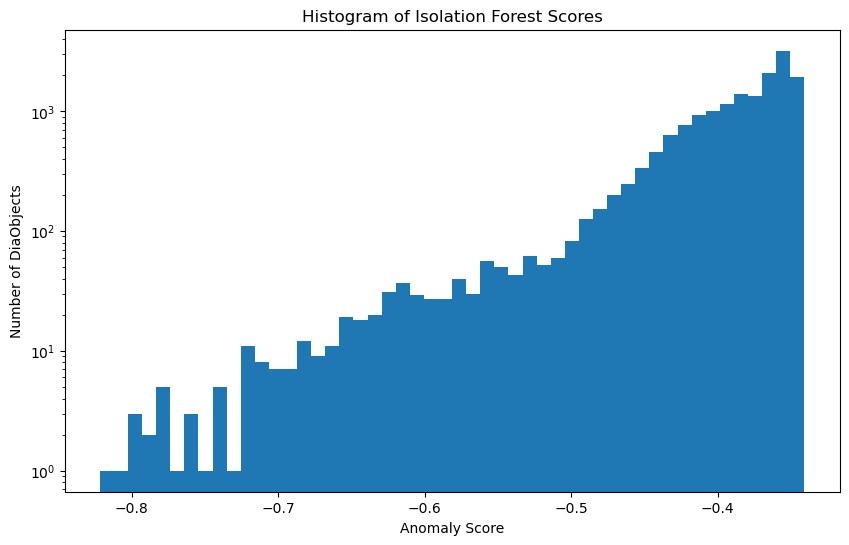

In [7]:
plt.figure(figsize=(10, 6))
plt.title("Histogram of Isolation Forest Scores")
plt.hist(scores, bins=50, log=True)
plt.xlabel("Anomaly Score")
plt.ylabel("Number of DiaObjects")
plt.show()

In [8]:
outlier_diaobject_ids = dia_objects.index[outlier_indices]

In [9]:
query_lightcurves = f"""
SELECT
    fsodo.diaObjectId,
    fsodo.band,
    fsodo.psfDiffFlux,
    fsodo.psfDiffFluxErr,
    vis.expMidptMJD
FROM
    dp1.ForcedSourceOnDiaObject AS fsodo
JOIN
    dp1.Visit AS vis ON vis.visit = fsodo.visit
WHERE
    fsodo.diaObjectId IN ({','.join(map(str, outlier_diaobject_ids))})
"""

job_lightcurves = service.submit_job(query_lightcurves)
job_lightcurves.run()
job_lightcurves.wait(phases=["COMPLETED", "ERROR"])
if job_lightcurves.phase == "ERROR":
    job_lightcurves.raise_if_error()

assert job_lightcurves.phase == "COMPLETED"
forced_source_outliers = job_lightcurves.fetch_result().to_table().to_pandas()

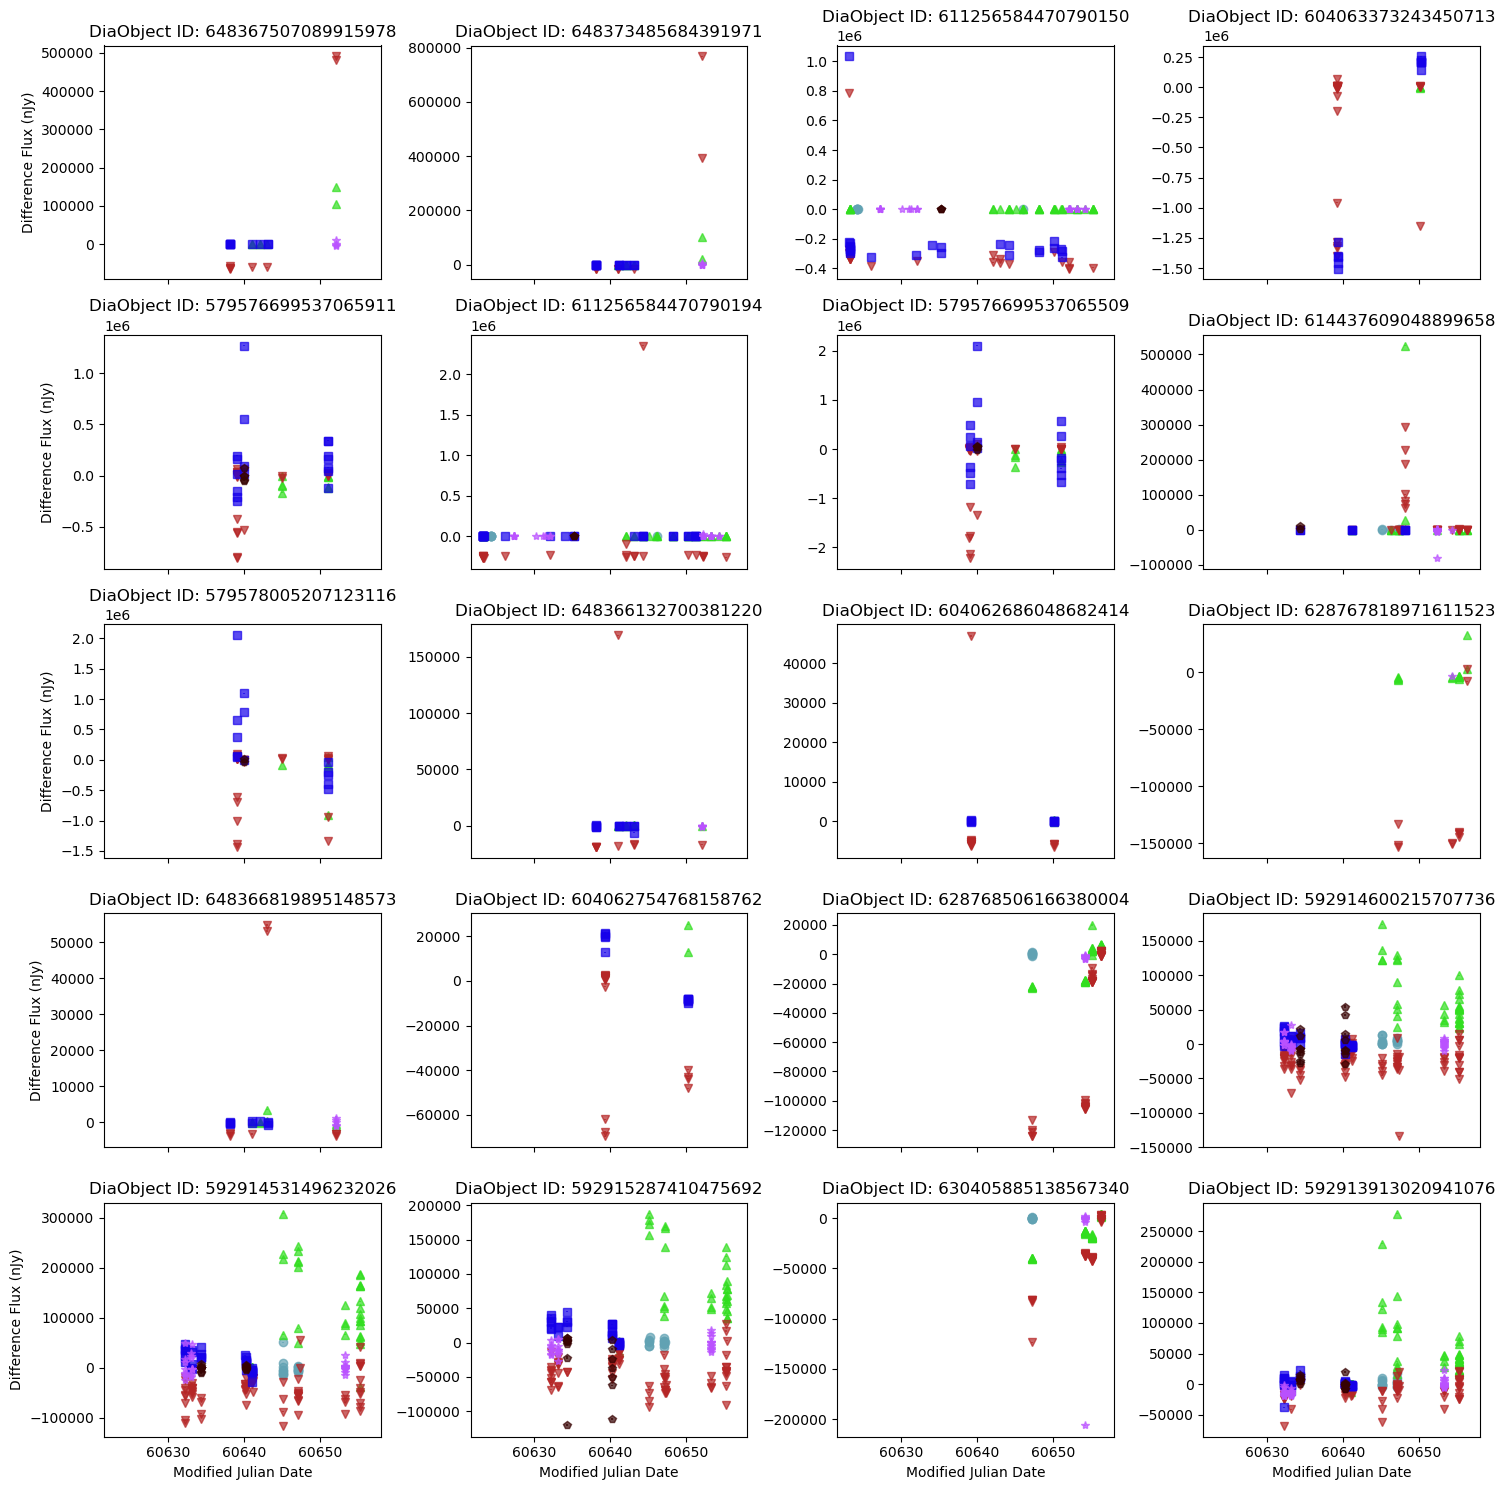

In [10]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=True)
axes = axes.flatten()

for i, diaobject_id in enumerate(outlier_diaobject_ids):
    ax = axes[i]
    object_data = forced_source_outliers[
        forced_source_outliers["diaObjectId"] == diaobject_id
    ]
    for band in filter_names:
        band_data = object_data[object_data["band"] == band]
        if len(band_data) > 0:
            ax.errorbar(
                band_data["expMidptMJD"],
                band_data["psfDiffFlux"],
                yerr=band_data["psfDiffFluxErr"],
                fmt=filter_symbols[band],
                color=filter_colors[band],
                label=band,
                alpha=0.7,
            )
    ax.set_title(f"DiaObject ID: {diaobject_id}")
    if i >= 16:
        ax.set_xlabel("Modified Julian Date")
    if i % 4 == 0:
        ax.set_ylabel("Difference Flux (nJy)")

plt.tight_layout()
plt.show()

In [11]:
top_outlier_id = outlier_diaobject_ids[0]
top_outlier_data = dia_objects.loc[top_outlier_id]
print("Top Outlier")
print(f"  DiaObject ID: {top_outlier_data.index[0]}")
print(f"  RA: {top_outlier_data['ra']}")
print(f"  Dec: {top_outlier_data['dec']}")
print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean']}")
print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma']}")
print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope']}")

Top Outlier
  DiaObject ID: ra
  RA: 37.99417473077787
  Dec: 7.2739802663929956
  r-band PSF Flux Mean: -44337.1875
  r-band PSF Flux Sigma: 282457.5359111508
  r-band PSF Flux Linear Slope: 25423.938938181407


Add comments about analysis

In [12]:
top_outlier_id = outlier_diaobject_ids[0]
top_outlier_data = dia_objects.loc[top_outlier_id]
print("Top Outlier")
print(f"  DiaObject ID: {top_outlier_id}")
print(f"  RA: {top_outlier_data['ra']}")
print(f"  Dec: {top_outlier_data['dec']}")
print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean']}")
print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma']}")
print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope']}")

Top Outlier
  DiaObject ID: 648367507089915978
  RA: 37.99417473077787
  Dec: 7.2739802663929956
  r-band PSF Flux Mean: -44337.1875
  r-band PSF Flux Sigma: 282457.5359111508
  r-band PSF Flux Linear Slope: 25423.938938181407


In [13]:
# for top_outlier_id in outlier_diaobject_ids:
#     top_outlier_data = dia_objects.loc[top_outlier_id]
#     print(f"  DiaObject ID: {top_outlier_id}")
#     print(f"  RA, DEC: {top_outlier_data['ra']} {top_outlier_data['dec']}")
#     print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean']}")
#     print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma']}")
#     print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope']}")
#     print("*"*20)

## 3. Run DistClassiPy: Anomalies

<div align="center">
<img src="media/dcpy-anomalies.gif" alt="Animation of DistClassiPy's anomaly detection method" width="450"/>
<br>
<em>Fig: A simplified model of how multiple distance metrics can be used to flag points which are far away from known classes.</em>
</div>



In [14]:
!pip install git+http://github.com/sidchaini/distclassipy
# pip install distclassipy

Defaulting to user installation because normal site-packages is not writeable
  Cloning http://github.com/sidchaini/distclassipy to /tmp/pip-req-build-kfuppes7
  Running command git clone --filter=blob:none --quiet http://github.com/sidchaini/distclassipy /tmp/pip-req-build-kfuppes7
  Resolved http://github.com/sidchaini/distclassipy to commit dbd4d98dc1a8aad8f02bfa622dc3c46766fa211a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [15]:
from distclassipy.anomaly import DistanceAnomaly

Now, we also need some labels for DistClassiPy to find an anchor to "known" classes. We can do this by cross matching DP1 with Gaia data (see ```2. gaia dp1 xmatch.ipynb```).

Here, let's load the cross match table generated in the other notebook.

In [16]:
# features = pd.read_parquet("../dp1anom/data/dp1_features_sc.parquet")
gaia_xmatch = pd.read_csv("gaia_matches.csv").set_index("diaObjectId")

In [17]:
common_objs = np.intersect1d(gaia_xmatch.index, dia_objects.index)
print(f"Found {len(common_objs)} objects common in Gaia DR3 and DP1")
gaia_classes = (
    gaia_xmatch.loc[common_objs, ["best_class_name"]]
    .reset_index(drop=False)
    .drop_duplicates()
    .set_index("diaObjectId")
)

Found 160 objects common in Gaia DR3 and DP1


In [18]:
gaia_classes.value_counts()

best_class_name
RR                 43
AGN                38
LPV                38
SOLAR_LIKE         17
ECL                11
RS                  5
YSO                 5
S                   3
Name: count, dtype: int64

In [19]:
y_knowns_df = gaia_classes["best_class_name"]
X_knowns_df = dia_objects.loc[
    y_knowns_df.index,
]

In [20]:
X_unknowns_df = dia_objects.loc[:, X_knowns_df.columns].drop(X_knowns_df.index)

In [21]:
model = DistanceAnomaly(cluster_agg="min", metric_agg="median", normalize_scores=True)

In [22]:
model.fit(X_knowns_df.to_numpy(), y_knowns_df.to_numpy())

,metrics,None
,cluster_agg,'min'
,metric_agg,'median'
,normalize_scores,True
,scale,True
,central_stat,'median'
,dispersion_stat,'std'
,contamination,0.1


In [23]:
scores = -model.decision_function(X_unknowns_df.to_numpy())
outlier_indices = np.argsort(scores)[:20]

In [24]:
outlier_indices = np.argsort(scores)[:20]

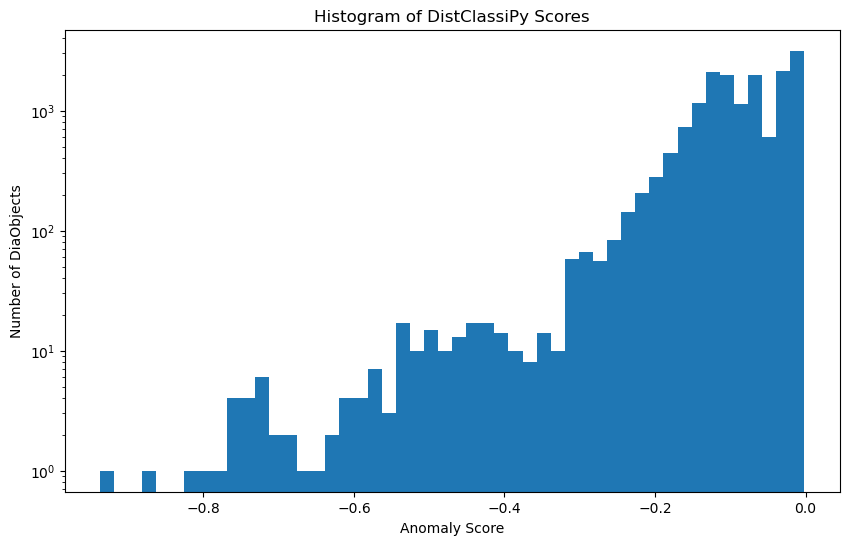

In [25]:
plt.figure(figsize=(10, 6))
plt.title("Histogram of DistClassiPy Scores")
plt.hist(scores, bins=50, log=True)
plt.xlabel("Anomaly Score")
plt.ylabel("Number of DiaObjects")
plt.show()

In [26]:
outlier_diaobject_ids = dia_objects.index[outlier_indices]

In [27]:
query_lightcurves = f"""
SELECT
    fsodo.diaObjectId,
    fsodo.band,
    fsodo.psfDiffFlux,
    fsodo.psfDiffFluxErr,
    vis.expMidptMJD
FROM
    dp1.ForcedSourceOnDiaObject AS fsodo
JOIN
    dp1.Visit AS vis ON vis.visit = fsodo.visit
WHERE
    fsodo.diaObjectId IN ({','.join(map(str, outlier_diaobject_ids))})
"""

job_lightcurves = service.submit_job(query_lightcurves)
job_lightcurves.run()
job_lightcurves.wait(phases=["COMPLETED", "ERROR"])
if job_lightcurves.phase == "ERROR":
    job_lightcurves.raise_if_error()

assert job_lightcurves.phase == "COMPLETED"
forced_source_outliers = job_lightcurves.fetch_result().to_table().to_pandas()

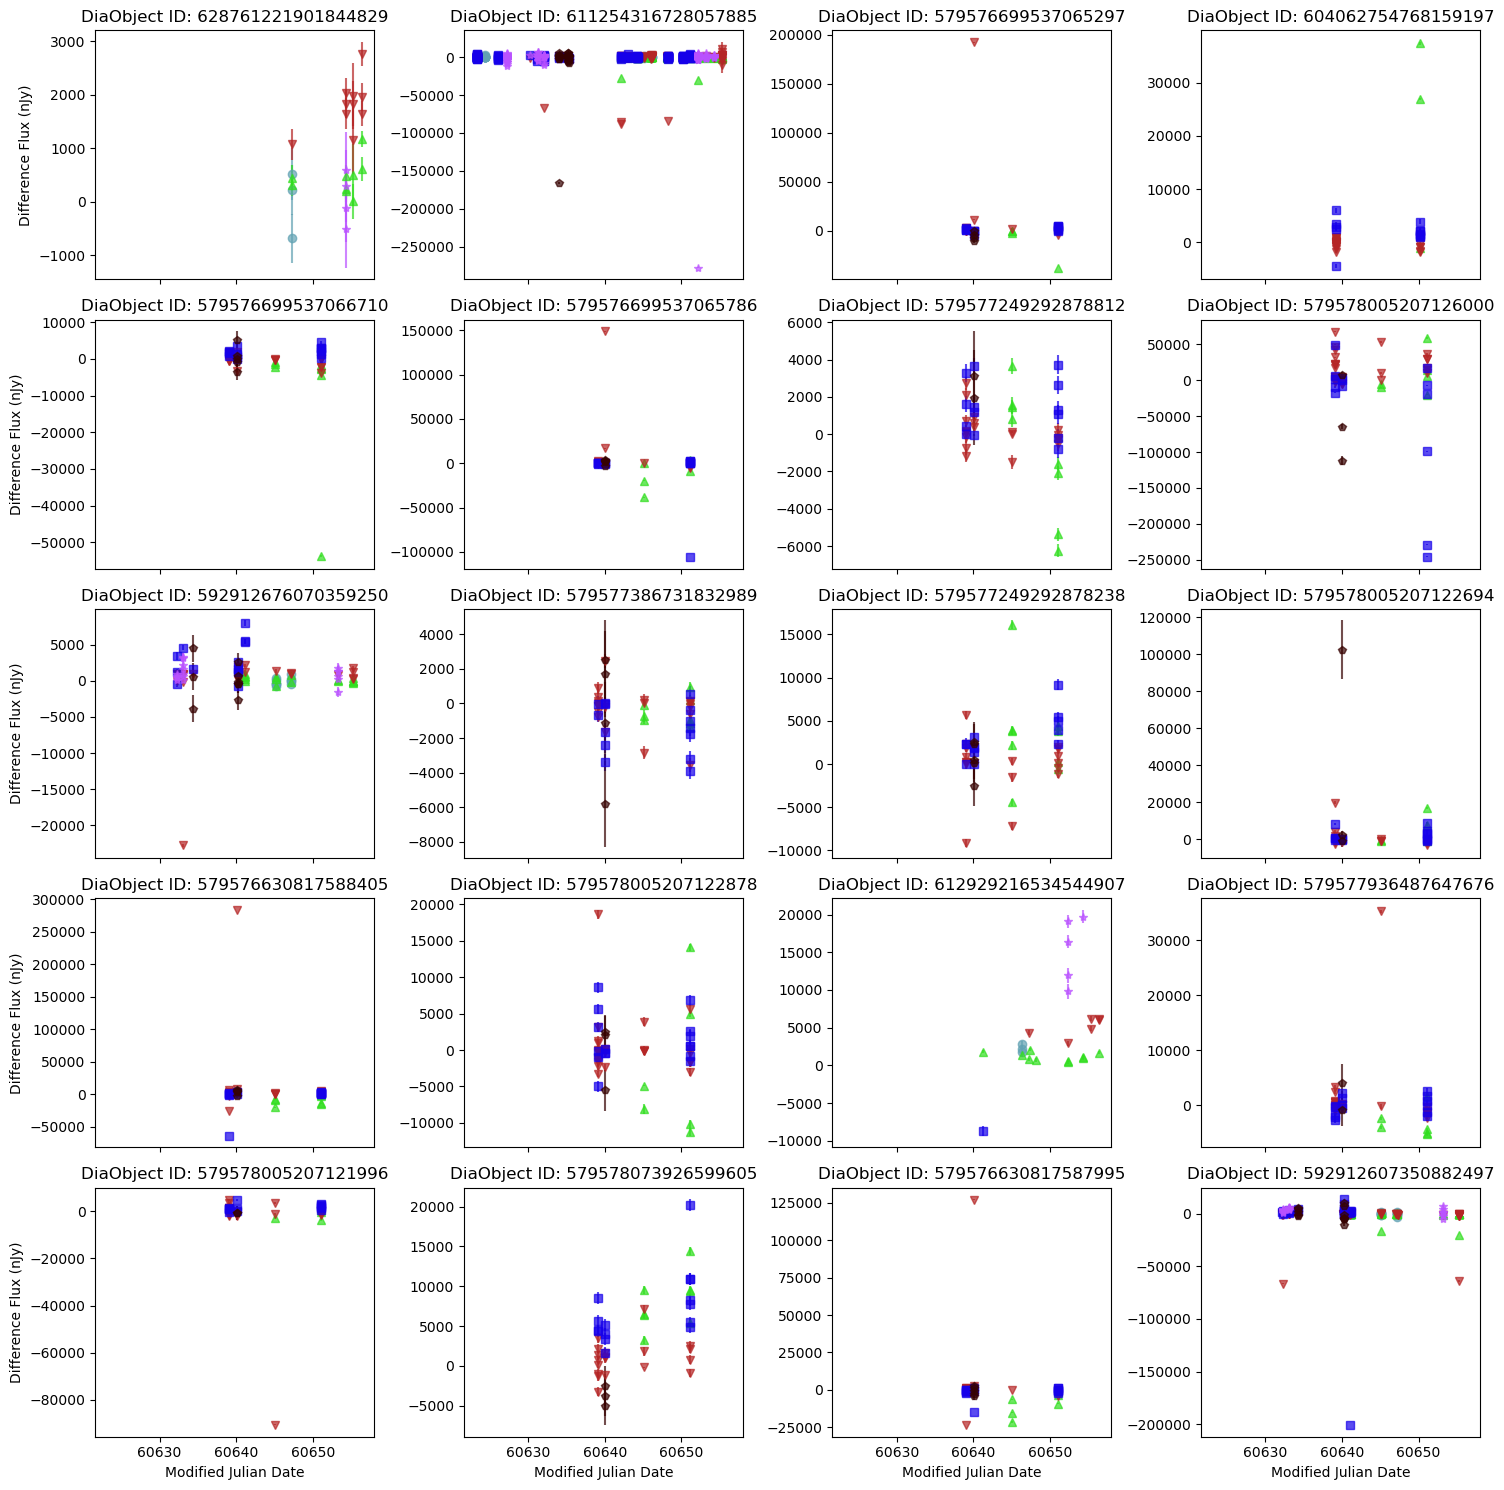

In [28]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=True)
axes = axes.flatten()

for i, diaobject_id in enumerate(outlier_diaobject_ids):
    ax = axes[i]
    object_data = forced_source_outliers[
        forced_source_outliers["diaObjectId"] == diaobject_id
    ]
    for band in filter_names:
        band_data = object_data[object_data["band"] == band]
        if len(band_data) > 0:
            ax.errorbar(
                band_data["expMidptMJD"],
                band_data["psfDiffFlux"],
                yerr=band_data["psfDiffFluxErr"],
                fmt=filter_symbols[band],
                color=filter_colors[band],
                label=band,
                alpha=0.7,
            )
    ax.set_title(f"DiaObject ID: {diaobject_id}")
    if i >= 16:
        ax.set_xlabel("Modified Julian Date")
    if i % 4 == 0:
        ax.set_ylabel("Difference Flux (nJy)")

plt.tight_layout()
plt.show()

In [29]:
top_outlier_id = outlier_diaobject_ids[0]
top_outlier_data = dia_objects.loc[top_outlier_id]
print("Top Outlier")
print(f"  DiaObject ID: {top_outlier_data.index[0]}")
print(f"  RA: {top_outlier_data['ra']}")
print(f"  Dec: {top_outlier_data['dec']}")
print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean']}")
print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma']}")
print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope']}")

Top Outlier
  DiaObject ID: ra
  RA: 105.93419608041346
  Dec: -10.819610648953816
  r-band PSF Flux Mean: 1952.1734619140625
  r-band PSF Flux Sigma: 432.36587587234925
  r-band PSF Flux Linear Slope: 80.76900058510354


In [30]:
# for top_outlier_id in outlier_diaobject_ids:
#     top_outlier_data = dia_objects.loc[top_outlier_id]
#     # print("Top Outlier")
#     print(f"  DiaObject ID: {top_outlier_id}")
#     print(f"  RA, DED: {top_outlier_data['ra']} {top_outlier_data['dec']}")
#     print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean']}")
#     print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma']}")
#     print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope']}")
#     print("*"*20)

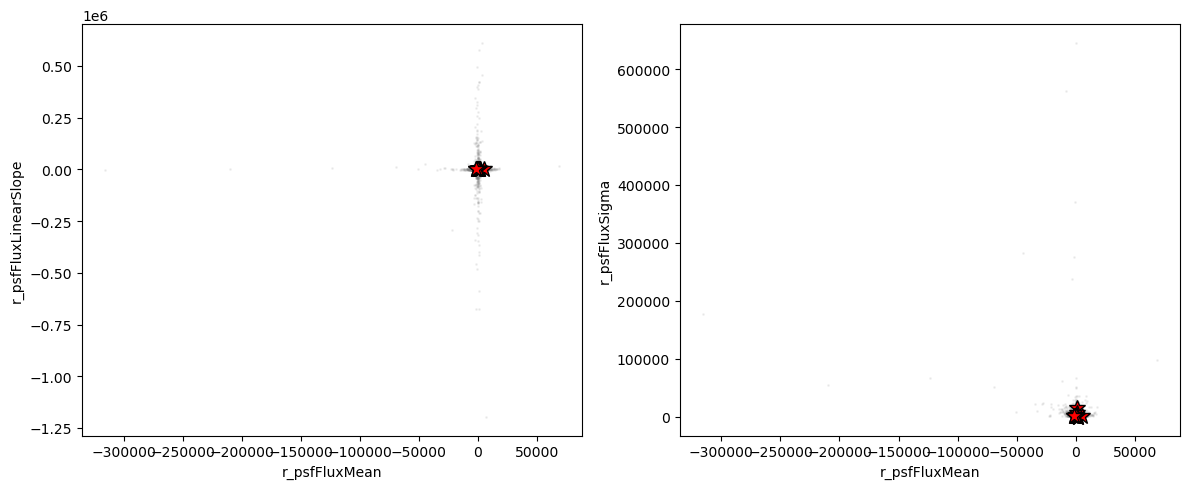

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=False, sharex=False)

params = [
    ('r_psfFluxMean', 'r_psfFluxLinearSlope'),
    ('r_psfFluxMean', 'r_psfFluxSigma'),
]

for j, (px, py) in enumerate(params):
    ax[j].plot(dia_objects[px], dia_objects[py], 'o', ms=1, color='grey', alpha=0.1)
    ax[j].set_xlabel(px)
    ax[j].set_ylabel(py)
    for i in outlier_diaobject_ids:
        ax[j].plot(dia_objects[px][i], dia_objects[py][i], '*', ms=12, color='red', mec='black')

plt.tight_layout()
plt.show()


## 4. Going further

Now, in this tutorial we only used photometric data available from the catalogs. For more detailed analysis, you could use a feature extractor on every light curve. For example: [ALeRCE](https://github.com/alercebroker/pipeline)([Sánchez-Sáez+21](https://ui.adsabs.harvard.edu/abs/2021AJ....161..141S/abstract)) or [```light-curve```]((https://github.com/light-curve/light-curve-python))[(Malanchev+21)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.5147M/abstract).

After obtaining these features for your light curve sample, you can perform anomaly detection very similarly to above.